**Objetivo:** Estudar como as linhas espectrais da molécula de HCl na banda 2-0 se alargam em função da temperatura.


 **1.** Verificar se os espectros simulados pelo Hitran provê os mesmos coeficientes de auto-alargamento em função da pressão estudados durante a graduação.

 **2.** Simular espectros com as mesmas pressões, mas em temperaturas diferentes e verificar o que acontece com os coeficientes de auto-alargamento em cada temperatura
 
 **3.** Fixar uma pressão e verificar como esse coeficiente varia somente na temperatura.

 **4.** Estudar uma maneira de determinar a dependência entre pressão e temperatura.

 **5.** Modelar matematicamente em termos de temperatura e pressão

 **6.** Validar esse modelo em dados reais

 **7.** Desenvolver modelos de Machine Learning para processamento de espectros 

# Importando pacotes

In [1]:
from SpectraGenerator.spectragenerator import SpectraGenerator
from SpectraProcessing.spectraprocessing import branchClassification, plotSpectrum
from SpectraFit.spectrafit import filterLine,singleLineFit, multipleLineFit

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


HAPI version: 1.2.2.3
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

# Simulando espectros e processando espectros

Uma banda espectral é formada por linhas/raias espectrais, essas linhas são provenientes das transições de energias rotacionais em uma molécula. Essas transições podem ser categorizadas por Ramas denominadas por rama R, rama P ou  rama Q. No caso da banda 2-0 do HCl, temos somente as Ramas R e P. Cada linha, além da categorização da rama, tem também um valor de J associado, para o HCl temos:

R = 0, 1, 2, 3, 4...

P = 1, 2, 3, 4...

Além do valor de J, podemos introduzir uma outra variável denotada por m, onde

m = -J, se for rama P,

m = J + 1, se for rama R

Ao simularmos um espectro, é necessário aplicarmos um pré-processamento para organizarmos os dados obtidos, visamos nessa parte categorizar as transições (R/P) e definir seus valores de J e m. 

Após a organização das linhas, precisaremos obter os coeficientes de auto-alargamento, e para isso será necessário obter a largura de cada raia espectral. Esse parâmetro será obtido mediante o ajuste não linear de cada linha espectral pelo perfil de Voigt. No meu tcc eu demonstrei que o perfil de Voigt é o melhor perfil que se ajusta nas linhas do HCl, além disso, o perfil de Voigt é um grande coringa, pois leva em consideração os efeitos simultâneos de colisão e efeito doppler.

**Tarefas:**

**1.** Identificar as raias espectrais

**2.** Categorizar as linhas em rama P ou rama R

**3.** Indicar a numeração de cada linha referente  a sua rama

**4.** Separar a raia do espectro.

**5.** Ajustar a linha utilizando o perfil de Voigt.

**6.** Armazenar todos os parâmetros obtidos do ajuste em um dataset.

**7.** Fazer isso para espectros em diferentes pressões e temperaturas.


Inicializando
Using SpectraGenerator/hitran_database

H35Cl
                     Lines parsed: 334
H37Cl
                     Lines parsed: 340
{'air': 0, 'self': 1}
3.542701 seconds elapsed for abscoef; nlines = 334


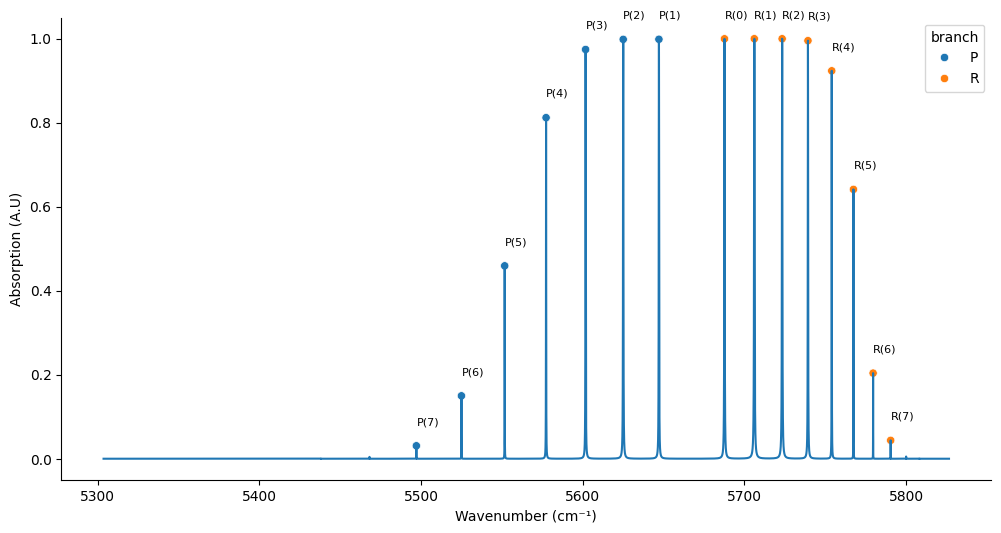

In [2]:
s = SpectraGenerator()

pressure = 0.1  #atm
temperature = 100 # Kelvin

optical_length = 10 #cm

#Simulando o espectro
s.simulateSpectra('H35Cl',{'air':0, 'self':1}, {'l':optical_length,'p':pressure,'T':temperature})

# Organizando as linhas
lines = branchClassification(s.spectra, findPeaksParams={'height':0},thresoldBranch=5665)

lines['pressure'] = pressure
lines['temperature'] = temperature

# Realizando o fit das linhas pelo perfil de Voigt

plotSpectrum(s.spectra,lines)

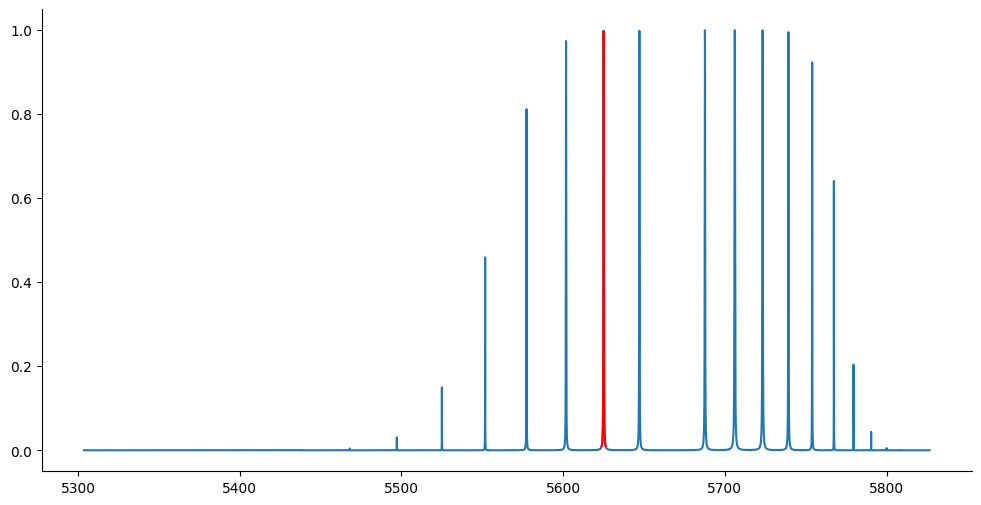

In [3]:
x,y = filterLine(s.spectra,lines.loc[5,'wavenumber'],lines.loc[5,'absorption'],0.01)

plt.plot(s.spectra['wavenumbers'],s.spectra['absorption'])
plt.plot(x,y,c='red')

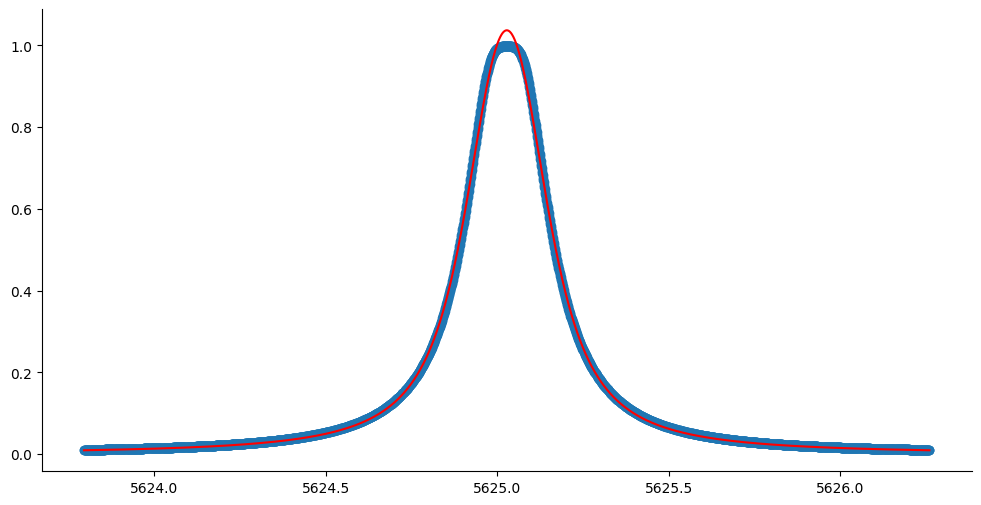

In [4]:
chute= 8e-3
final, result, params, successful = singleLineFit(y, x, lines.loc[5,'wavenumber'],chute, chute, vgamma=True, vsigma=True)

plt.scatter(x=x,y=y)
plt.plot(x,final,c='red')
result

In [5]:
s = SpectraGenerator()

Inicializando
Using SpectraGenerator/hitran_database

H35Cl
                     Lines parsed: 334
H37Cl
                     Lines parsed: 340


In [42]:
results = pd.DataFrame()
# gerando lista de pressões e temperaturas para a geração dos espectros

temperatures = [296, 400] # kelvin

pressures = [0.1, 0.5] # atm

optical_length = 10 # cm


print(f"Temperatures (K): {temperatures}\nPressures (atm): {pressures}\n\n")

for temperature in temperatures:
    for pressure in pressures:

        print(f'-----------Fitting for {temperature}K and {pressure} atm-----------')
        #Simulando o espectro
        s.simulateSpectra('H35Cl',{'air':0, 'self':1}, {'l':optical_length,'p':pressure,'T':temperature})

        # Organizando as linhas
        lines = branchClassification(s.spectra, findPeaksParams={'height':0}, thresoldBranch = 5665)

        lines['pressure'] = pressure
        lines['temperature'] = temperature

        fitted_params = multipleLineFit(s.spectra, lines, 0.01)

        lines = pd.concat([lines,fitted_params],axis=1)

        results = pd.concat([results,lines], axis = 0, ignore_index=True)

Temperatures (K): [296, 400]
Pressures (atm): [0.1, 0.5]


-----------Fitting for 296K and 0.1 atm-----------
{'air': 0, 'self': 1}
3.821025 seconds elapsed for abscoef; nlines = 334
P(12) -> 0.9999668804295472
P(11) -> 0.9999777087827824
P(10) -> 0.9999987993429263
P(9) -> 0.9982201533097642
P(8) -> 0.9999847273923703
P(7) -> 0.9999735775209637
P(6) -> 0.9999539812328598
P(5) -> 0.9999127525907688
P(4) -> 0.9998621195203248
P(3) -> 0.9998143170209668
P(2) -> 0.9987701480341654
P(1) -> 0.9999542992306133
R(0) -> 0.9999182750199396
R(1) -> 0.9996384044830962
R(2) -> 0.9994756799935681
R(3) -> 0.9994554554335883
R(4) -> 0.999524638796342
R(5) -> 0.9996538198770821
R(6) -> 0.9997819817044309
R(7) -> 0.996933352398325
R(8) -> 0.9999330964185488
R(9) -> 0.999983307111366
R(10) -> 0.999993557762951
R(11) -> 0.9999994704460404
R(12) -> 0.9997574540371745
-----------Fitting for 296K and 0.5 atm-----------
{'air': 0, 'self': 1}
3.486261 seconds elapsed for abscoef; nlines = 334
P(12) -> 0.99999

In [63]:
plt.style.use('dark_background')

In [80]:
results['ratio'] = results['sigma'] / results['gamma']

<Axes: xlabel='ratio', ylabel='fwhm'>

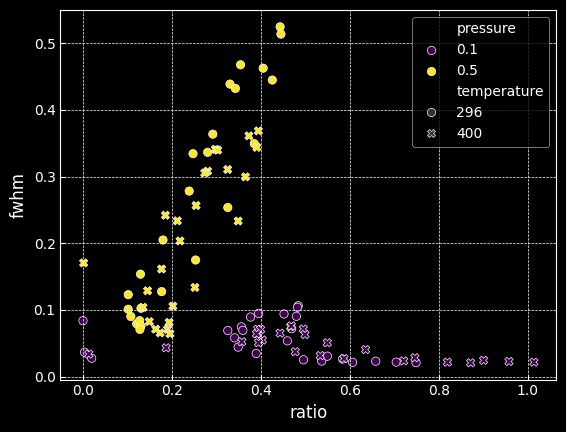

In [92]:
sns.scatterplot(data= results, x='ratio', y='fwhm', hue='pressure',style='temperature', palette='viridis')